In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('arxiv_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51774 entries, 0 to 51773
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     51774 non-null  object
 1   summaries  51774 non-null  object
 2   terms      51774 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [4]:
df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [5]:
df = df.drop_duplicates(subset=['titles', 'summaries'])

In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38985 entries, 0 to 51772
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     38985 non-null  object
 1   summaries  38985 non-null  object
 2   terms      38985 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [8]:
df_first_1000 = df.head(1000)
df_first_1000.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     1000 non-null   object
 1   summaries  1000 non-null   object
 2   terms      1000 non-null   object
dtypes: object(3)
memory usage: 31.2+ KB


In [ ]:
df_first_1000.to_csv('first_1000_records.csv', index=False)  # Set index=False to avoid writing row indices


### Document Length Analysis
We analyze the distribution of summaries length to understand content variation.


C:\Users\srajb\AppData\Local\Temp\ipykernel_1368\502428772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_1000["summary_length"] = df_first_1000["summaries"].apply(lambda x: len(x.split()))


count    1000.000000
mean      177.610000
std        45.728558
min        49.000000
25%       147.000000
50%       176.000000
75%       206.250000
max       312.000000
Name: summary_length, dtype: float64


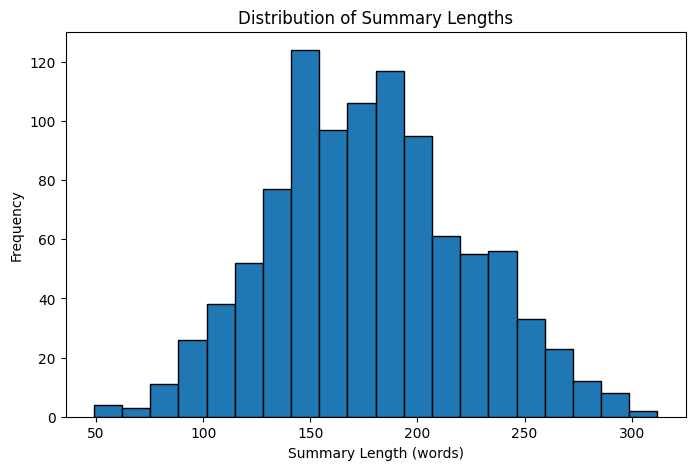

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Compute document lengths
df_first_1000["summary_length"] = df_first_1000["summaries"].apply(lambda x: len(x.split()))

# Display summary statistics
print(df_first_1000["summary_length"].describe())

# Plot histogram of document lengths
plt.figure(figsize=(8,5))
plt.hist(df_first_1000["summary_length"], bins=20, edgecolor='black')
plt.xlabel("Summary Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Summary Lengths")
plt.show()


In [11]:
df_first_1000.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   titles          1000 non-null   object
 1   summaries       1000 non-null   object
 2   terms           1000 non-null   object
 3   summary_length  1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 39.1+ KB


In [12]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('expand_frame_repr', False)  # Prevent line wrapping

# Print DataFrame
print(df_first_1000.head(20))

                                                                                                                           titles                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [13]:
# 3. Vocabulary Size Calculation
# To get an estimate of the dataset's vocabulary size:

from collections import Counter

# Join all text data and count unique words
all_words = " ".join(df_first_1000["summaries"]).split()
vocab_count = Counter(all_words)

print(f"Vocabulary size: {len(vocab_count)}")

Vocabulary size: 16748


                                           Topic  Count
0                                          cs.CV    955
1                                          cs.LG    256
6                                        eess.IV    118
14                                       stat.ML     89
2                                          cs.AI     68
5                                          cs.NE     18
9                                          cs.RO     15
24                                         cs.CL     10
30                                         cs.CG      9
11                                         cs.CR      8
29                                       math.NA      8
25                                         cs.GR      7
10                                         I.4.6      6
26                                         cs.MM      5
28                                         cs.NA      5
23                                       eess.SP      4
18                                      q-bio.TO

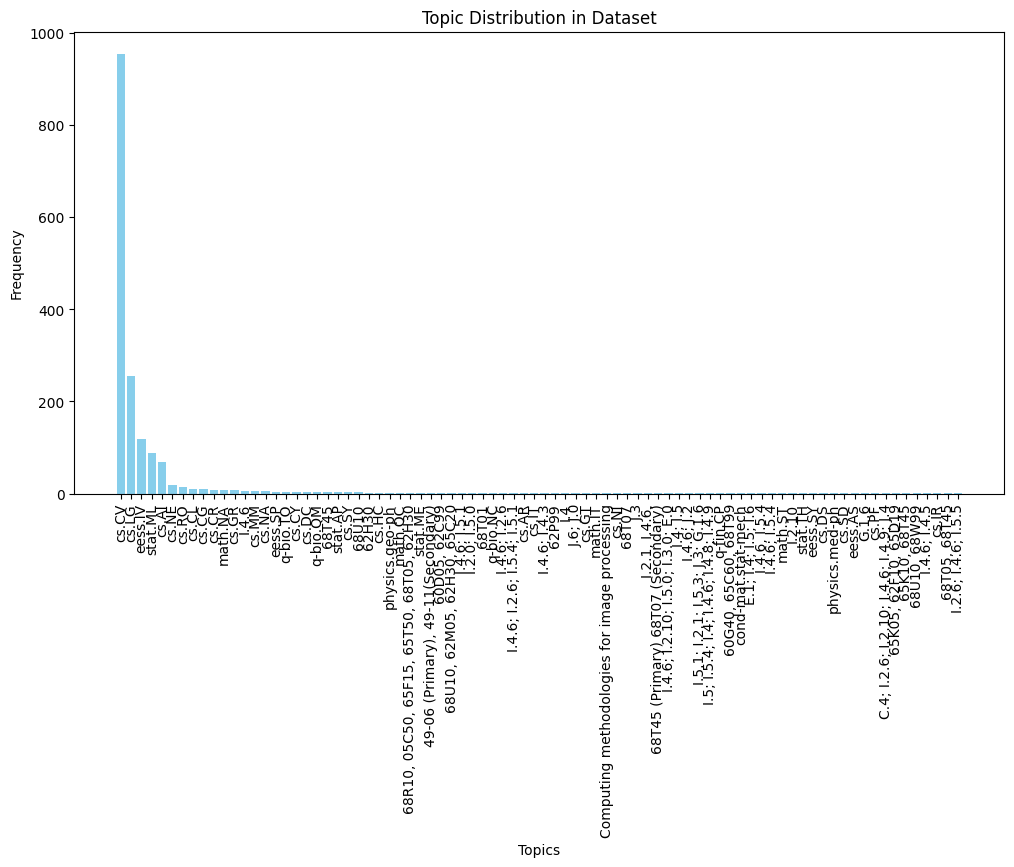

In [14]:
# # 4. Topic Distribution Analysis
# # The terms column contains multiple topic labels per document. We will flatten and count their occurrences.

# from collections import Counter
# import pandas as pd
# import matplotlib.pyplot as plt

# # Count occurrences of each unique title (topic)
# topic_counts = df["terms"].value_counts()

# # Convert to DataFrame for visualization
# topic_df = topic_counts.reset_index()
# topic_df.columns = ["Topic", "Count"]

# # Display topic frequency
# print(topic_df)

# # Plot topic distribution
# plt.figure(figsize=(10, 5))
# plt.bar(topic_df["Topic"], topic_df["Count"], color='skyblue')
# plt.xticks(rotation=90)  # Rotate for better readability if too many topics
# plt.xlabel("Topics")
# plt.ylabel("Frequency")
# plt.title("Topic Distribution in Dataset")
# plt.show()

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import ast  # To safely convert string lists into actual lists

# Flatten the topic lists
all_topics = []
for topics in df_first_1000["terms"]:
    topic_list = ast.literal_eval(topics)  # Convert string list to actual list
    all_topics.extend(topic_list)  # Add all topics to a single list

# Count occurrences of each unique topic
topic_counts = Counter(all_topics)

# Convert to DataFrame for visualization
topic_df = pd.DataFrame(topic_counts.items(), columns=["Topic", "Count"]).sort_values(by="Count", ascending=False)

# Display topic frequency
print(topic_df)

# Plot topic distribution
plt.figure(figsize=(12, 6))
plt.bar(topic_df["Topic"], topic_df["Count"], color='skyblue')
plt.xticks(rotation=90)  # Rotate for better readability if too many topics
plt.xlabel("Topics")
plt.ylabel("Frequency")
plt.title("Topic Distribution in Dataset")
plt.show()


In [15]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load models
embedding_model = SentenceTransformer('BAAI/bge-small-en')
generation_model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-small')
tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-small')


# 2. Hardcoded Questions (replace dynamic generation)
# hardcoded_questions = [
#     "What does deep reinforcement learning combine?", #['cs.CV', 'cs.AI']
#     "What is the main focus of the research in this paper regarding Blockchain technologies?", #['cs.LG', 'q-fin.ST', 'stat.ML']
#     "What does pose information represent in Capsule Networks?", #['cs.CV', 'cs.LG']
#     "What are the key components of VA-GAN?", #['cs.CV']
#     "How does the paper contribute to understanding the network dynamics behind cryptocurrencies like Bitcoin?",#['cs.LG', 'q-fin.ST', 'stat.ML']
#     "What specific image processing algorithms were used to transform RNA sequences into gene motifs for the CNN classification?", #['cs.LG', 'q-bio.QM']
#     "What is the role of camera-aware domain adaptation in the proposed method?", #['cs.CV']
#     "What is the primary goal of the Structure Transfer Machine (STM) method?", #['cs.CV', 'cs.RO', 'eess.IV']
#     "What is the role of the manifold structure in STM?", #['cs.CV', 'cs.RO', 'eess.IV']
#     "Where can the source code for STM be accessed?", #['cs.CV', 'cs.RO', 'eess.IV']
#     "What are the three main challenges in multi-task reinforcement learning?", #['cs.LG', 'cs.AI', 'stat.ML']
#     "What is the main goal of self-supervised methods in reinforcement learning?", #['cs.LG', 'cs.CV', 'stat.ML']
#     "How does the proposed Local and Global Diffusion (LGD) framework address this limitation?", #['cs.LG', 'cs.SI', 'stat.ML']
#     "What is the role of diffusions in the LGD network?",  #['cs.LG', 'cs.SI', 'stat.ML']
#     "How many categories and images are included in the UDD dataset?" #['cs.CV']
# ]
#Thoufiq
# hardcoded_questions = [
#     "What are the three stages of the SLaT method for segmenting degraded color images?",  # ['cs.CV', 'math.NA', '65F22', 'I.4.6']
#     "How does the proposed method in the paper 'Human Recognition Using Face in Computed Tomography' improve patient identification?",  # ['cs.CV']
#     "What is the main advantage of using robustified controllers in sim-to-real transfer learning for robotic tasks?",  # ['cs.LG', 'stat.ML']
#     "What makes the Mapillary Traffic Sign Dataset unique compared to other traffic sign datasets?",  # ['cs.CV']
#     "How does the human body parts tracking system (HBPT) proposed in the paper improve activity recognition?",  # ['cs.CV', 'eess.IV']
#     "What is the key contribution of the adversarial stacked auto-encoders approach for fair representation learning?",  # ['cs.LG', 'cs.AI']
#     "How does the synthetic data generation framework for text recognition improve handwritten word recognition tasks?",  # ['cs.CV']
#     "What is the significance of the temporal normalization transform in motion equivariant networks for event cameras?",  # ['cs.CV']
#     "How does adversarial training improve monocular depth estimation compared to traditional regression-based methods?",  # ['cs.CV']
#     "What is the role of active inference in Bayesian policy selection, and how does it compare to reinforcement learning?",  # ['cs.LG', 'cs.AI', 'cs.NE']
#     "How do Pathfinder Discovery Networks (PDNs) improve neural message passing in graph-based learning tasks?",  # ['cs.LG', 'cs.AI', 'cs.SI']
#     "What techniques are proposed in the paper to enable sub-meter localization on resource-constrained platforms using video?",  # ['cs.CV']
#     "What are the novel empirical losses proposed in the Continuous Conditional Generative Adversarial Networks (CcGAN) paper?",  # ['cs.CV', 'cs.LG', 'stat.ML']
#     "How does the interactive beard and hair synthesis method using generative models achieve high-fidelity results?",  # ['cs.CV', 'cs.GR', 'cs.HC', 'cs.LG']
#     "What challenges does the paper 'Motion Equivariant Networks for Event Cameras' address in event-based learning tasks?"  # ['cs.CV']
# ]
hardcoded_questions = [
    "What issue does consistency training face?",
    "What is EHT used for?",
    "What challenge do deep models face?",
    "How does transfer learning reduce data labeling costs?",
    "What is StructBoost in boosting algorithms?",
    "What problem does Augmented CycleGAN address?",
    "What does the new algorithm for transductive inference optimize?",
    "What does DSAL combine for image segmentation?",
    "What problem does StructBoost address in multi-source domain adaptation?",
    "What is the benefit of using surrogate maximization for performance metrics?",
    "How does the point-set kernel measure compute similarity between objects?",
    "How does the 'Adversarial Payload Loss' evade malware detection while preserving functionality?",
    "How does AI-powered 3D image segmentation enable personalized treatment planning in oncology?",
    "What strategies can be used to enhance teamwork and communication in Agile environments?",
    "How can data-driven insights optimize customer support in retail environments?"
]

# 3. Evaluate RAG Model based on hardcoded questions
def evaluate_rag(df, questions, top_k=3):
    results = []

    for question in questions:
        # Embed the question
        query_embedding = embedding_model.encode(question, convert_to_tensor=True)

        # Embed all documents in the dataset
        doc_embeddings = embedding_model.encode(df['summaries'].tolist(), convert_to_tensor=True)

        # Retrieve top-k relevant documents based on similarity
        similarities = util.pytorch_cos_sim(query_embedding, doc_embeddings)[0]

        # Make a copy of the array to avoid negative stride errors
        similarities_copy = similarities.cpu().numpy().copy()

        top_indices = np.argsort(similarities_copy)[-top_k:][::-1]

        retrieved_docs = df.iloc[top_indices]

        # Generate an answer based on the retrieved documents
        doc_context = " ".join(retrieved_docs['summaries'].tolist())
        input_text = f"Answer the question: {question} Based on the following documents: {doc_context[:1500]}"

        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="longest", max_length=1024)
        outputs = generation_model.generate(**inputs, max_length=150, num_return_sequences=1)
        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Store the results
        results.append({
            'question': question,
            'answer': answer,
            'retrieved_docs': retrieved_docs['summaries'].tolist(),
            'retrieved_titles': retrieved_docs['titles'].tolist(),
            'retrieved_terms': retrieved_docs['terms'].tolist(),
            'similarities': similarities_copy[top_indices].tolist()  # Using the copied similarities array
        })

    return pd.DataFrame(results)

c:\Users\srajb\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [16]:
# Get results from the RAG evaluation
results_df = evaluate_rag(df_first_1000, hardcoded_questions)

In [ ]:
# Save Final Results
results_df.to_csv('rag_evaluation_results_first_1000_records.csv', index=False)
print("Evaluation completed and results saved to 'rag_evaluation_results.csv'.")

Evaluation completed and results saved to 'rag_evaluation_results.csv'.


| Number | Evaluation | Reason                                                                 | Similarities |
|--------|------------|------------------------------------------------------------------------|------------|
| 1      | Missing    | Document retrieval fail                                                | [0.839682936668396, 0.8354004621505737, 0.8351045846939087]|
| 2      | Missing    | Document retrieval fail                                                | [0.8018316030502319, 0.7984381914138794, 0.7838506102561951]|
| 3      | Missing    | Document retrieval fail                                                | [0.8471152782440186, 0.8460106253623962, 0.8458845615386963]|
| 4      | Correct    | Document retrieval success. Failed to answer                           | [0.9167786240577698, 0.8745719194412231, 0.8726475238800049]|
| 5      | Correct    | Document retrieval success. Right answer                              | [0.9142849445343018, 0.8487935066223145, 0.8477636575698853]|
| 6      | Correct    | Document retrieval success. Right answer                              | [0.8618714809417725, 0.8375003337860107, 0.8293293118476868]|
| 7      | Correct    | Document retrieval success. But the answer was generated from the 2nd document | [0.9107867479324341, 0.8744175434112549, 0.8731463551521301]|
| 8      | Missing    | Document retrieval fail                                                | [0.8865311145782471, 0.8848080039024353, 0.8827061653137207]|
| 9      | Correct    | Document retrieval success. Right answer                              | [0.8869342803955078, 0.8852487206459045, 0.8783530592918396]|
| 10     | Correct    | Document retrieval success. Right answer                              | [0.8967105746269226, 0.8617841005325317, 0.8603100180625916]|
| 11     | Correct    | Document retrieval success. Almost Right answer                       | [0.9056169390678406, 0.8723191022872925, 0.8708831071853638]|
| 12     | Correct    | Document retrieval success. Right answer                              | [0.8960573673248291, 0.8749409914016724, 0.8604234457015991]|
| 13     | Correct    | Document retrieval success. Almost Right answer                       | [0.9105475544929504, 0.9061556458473206, 0.90566086769104]|
| 14     | Incorrect  | This question was out of the topics present in data                   | [0.8065434694290161, 0.8056607246398926, 0.804391622543335]|
| 15     | Incorrect  | This question was out of the topics present in data                   | [0.8304593563079834, 0.8281747102737427, 0.8260115385055542]|

True Positives (TP): Documents that are Correct and relevant.

False Positives (FP): Documents that are Incorrect but were retrieved.

False Negatives (FN): Documents that should have been retrieved but were marked as Missing.

True Negatives (TN): Documents that are Missing and should not have been retrieved.

### Labeling Based on the Manual Evaluation
From the given dataset:

Correct: 4, 5, 6, 7, 9, 10, 11, 12, 13 → 9 documents
Incorrect: 14, 15 → 2 documents
Missing: 1, 2, 3, 8 → 4 documents

##  Topic Representation and Performance Differences
**Well-represented Topics**: For topics like AI, machine learning, and healthcare, document retrieval success was lower. While relevant documents were retrieved, the answers generated were often incomplete or inaccurate, indicating that more data did not always lead to better responses.

**Poorly Represented Topics**: For poorly represented or out-of-scope topics, retrieval success was higher, but due to the lack of relevant documents, the model struggled to provide meaningful answers, leading to more incorrect or failed responses.

## Cosine similarity
Cosine similarity measures the similarity between two vectors by calculating the cosine of the angle between them. It’s used in information retrieval to compare a query to documents in a database—higher similarity means more relevance.

## Limitations
**Lack of Semantic Understanding**: It doesn't capture meaning or context, only the words used, so similar ideas with different wording can be missed.

**Vector Length Sensitivity**: It ignores the magnitude of vectors, so longer documents may appear more relevant even if they're not.

**Sparse Representations**: In models like TF-IDF, sparse vectors (many zero values) can lead to inaccurate similarity calculations.

## Retrieval Failure 
### Example 1
In our case, where the query is "What does DSAL combine for image segmentation?", the retrieval failure happens because the search system places more emphasis on common or frequent terms like "image segmentation" and less weight on the more specific term "DSAL".
#### How this happens:
Cosine similarity compares the vector representations of the query and documents. If the vector for "image segmentation" in the query is very similar to the vector in a document but "DSAL" is not mentioned as frequently in the document, the overall cosine similarity score might still be low due to the absence of the key term "DSAL."
### Example 2
Where the query is "What is EHT used for?", the retrieval failure happens.
#### How this happens:
The query “EHT” may have been loosely connected to terms like “segmentation,” or “image processing,” causing the system to retrieve unrelated documents. Additionally, The system might not correctly distinguish between the intended use of "EHT" in the context of semantic segmentation of urban images and other fields like medical image segmentation, where segmentation techniques are mentioned but unrelated to the query.









## Question 5: Manual evaluation of Generated Responses against Retrieved Documents for Model Hallucination and Quality of Generated Responses

The answers generated by the model was compared against the 3 documents retrieved for each of the questions respectively and the following results were found


| Question Number | Response source | Correct Answer present in Document | Response Evaluation | Overall Quality |
|-----------------|-----------------|------------------------------------|---------------------|-----------------|
|  1 | Retrieved Document | No | Incorrect | Not meaningful, Random answer generated |
|  2 | Retrieved Document | No | Incorrect | General Answer on the most used term in the documents|
|  3 | Retrieved Document | No | Incorrect | Not a meaningful answer, Random term generated |
|  4 | Retrieved Document | Yes | Incorrect | Not a meaningful answer, Random term generated |
|  5 | Retrieved Document | Yes | Correct | High Quality, well structured and meaningful |
|  6 | Retrieved Document | Yes | Correct | High quality, well structured, meaningful |
|  7 | Retrieved Document | Yes | Incorrect | Not meaningful, Random answer generated|
|  8 | Retrieved Document | No | Incorrect | Not meaningful, Random term generated|
|  9 | Retrieved Document | Yes | Correct | Low Quality - Answer generated is almost correct but less meaningful and too general | 
| 10 | Retrieved DOcument | Yes | Correct | Low Quality -  Not well structured and incomplete but can be considered correct |
| 11 | Retrieved Document | Yes | Incorrect | Not meaningful, Random term generated |
| 12 | Retrieved Document | Yes | Correct | High Quality, well structured and meaningful | 
| 13 | Retrieved Document | Yes | Correct | High quality, well structured and meaningful |
| 14 | Retrieved Document | No | Incorrect | Random term generated, question with unrelated topic from data |
| 15 | Retrieved Document | No | Incorrect | Random term generated, question with unrelated topic from data |

Henece, there was no hallucinations present in the model. However only 7 answers out of 15 were correct answers which gives the following 

`True Positives (TP)`: The document has the correct answer and the response is correct.
Questions: 5, 6, 9, 10, 12, 13
Count: 6


`False Positives (FP)`: The document does not have the correct answer, but the response is still marked as correct.
Questions: None
Count: 0

`True Negatives (TN)`: The document does not have the correct answer, and the response is incorrect.
Questions: 1, 2, 3, 8, 14, 15
Count: 6

`False Negatives (FN)`: The document has the correct answer, but the response is incorrect.
Questions: 4, 7, 11
Count: 3

#### Summary:
` True Positives (TP): 6 `

` False Positives (FP): 0 `

` True Negatives (TN): 6 `

` False Negatives (FN): 3 `


Calculating the Precision, Recall, F1-Score and Accuracy of the generated Answers, we have the following:

Precision = `TP/(TP+FP)` = `6 / (6 + 0)` = `1`

Recall = `TP/TP+FN` = `6 / (6 + 3)` = `0.6667`

F1-Score = `2 x Precision x Recall / (Precision + Recall)` = `2 x (1 * 0.6667) / (1 + 0.6667)` = `0.8`

Accuracy = `TP + FN / (TP + FN + FP + FN)` = `(6+6) / (6 + 6 + 0 + 3)` = `0.8`


Hence as per the manual evaluation of the model's generated responses, we get the F1 Score of 0.8 and Accuracy of 80%.

## Overall Quality of Answers

Looking at the generated Answers, we find that there are 4 categories of response generated

1. `High Quality Answers`: These are the answers that are well structured and coherent. These are correct answers that are referenced from the retrieved documents and not randomly generated. 4 of the answers generated by the RAG was High Quality which is only 26.67%.

2. `Low Quality Answers`: These are the answers that are not very coherent and well structured and contains partial answers. The answers are taken from the retrieved documents. 2 of the answers generated by the RAG was Low quality which is 13.33%

3. `Not Meaningful Answers`: These are the answers that are randomly generated from the Documents and doesn't answer the question at all. 9 out of 15 (60%) answers generated by the RAG was not meaningful which is quite high for the model.

## Overall Performance of RAG based on Response

Looking at the numbers above, we can evaluate the RAG to not be much efficient. It is generating more non-meaningful answers rather than meaningful answers. It generated only 40% meaningful answers out of which only approx 26% were high wuality. Hence there is a lot of room for improvement in the RAG.

